<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/collaborative_filtering/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from fastai.collab import *
from fastai.tabular.all import *

# Collaborative Filtering from scratch - Movie Reviews

This notebook, based on the work [here](https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive/notebook), is a deep dive into how collaborative filtering works. I will be using collaborative filtering to recommend movies based on the preferences of other users and I will build the model from scratch, to help me gain a deeper understanding.

**So, what is collaborative filtering?**
Collaborative filtering is a method whereby a user's preferences are predicted based on the preferences of other users. It is underpinned by the assumption that people who agreed in the past will agree in the future.

The key foundational idea is **latent factors**. For example, Netflix don't need to ask you and keep a database of exactly which genres, film lengths, and time periods you like. Latent factors will be the parameters, unspecified in what they represent, used to compare the preferences of various users. We use the parameters to understand the likelihood that a person will like a product.

However, collaborative filtering isn't entirely for Netflix! There is a general class of problems collaborative filtering can solve and we generally refer to **items** which could be movies, links, diagnoses and many more...

## Data Extraction

Let's start by gathering some data  representing movie ratings from MovieLens dataset. Since this model is being used to inform my learning, rather than produce useful results, we will use a subset of the data for speed.

In [3]:
path = untar_data(URLs.ML_100k)

In [4]:
df = pd.read_csv(path/'u.data', # README specifies location of data
                 delimiter='\t', # README specifies tab separated file or TSV
                 header=None, # README specifies no labelled columns
                 names=['user', 'movie', 'rating', 'timestamp']) # we can add our own column names

In [5]:
df.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


It is useful to understand what this dataset  looks like cross-tabulated. Essentially, we want to fill the missing spots with predictions. This is called **matrix completion** which is the core of collaborative filtering. These predictions will represent the predicted rating the user will give the movie, based on other users preferences. This could assist in making recommendations and assisting users to discover new content.

It's worth noting that the values we try to predict don't have to be ratings, it could even just be 1s and 0s, representing whether a user purchased a product.

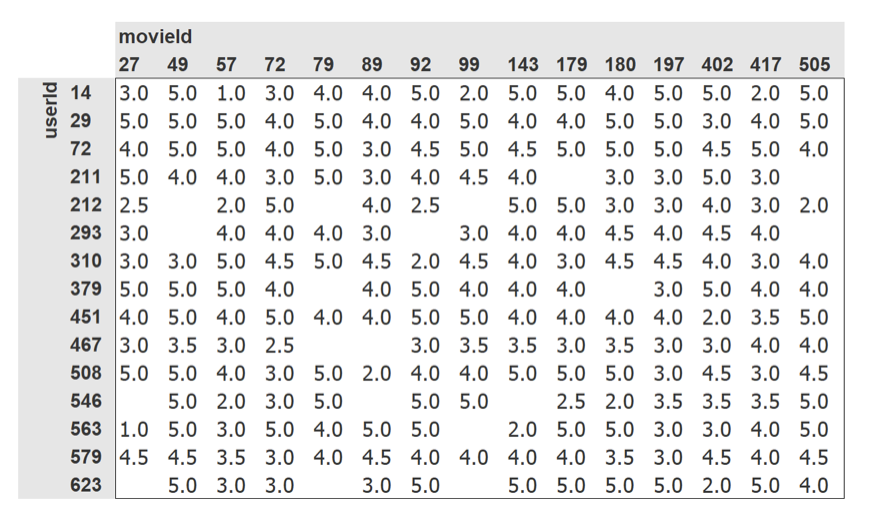

## Latent Factors

The next step is to define our latent factors, which will be a set of parameters for each movie and user.

We will take the **dot product** of the movie parameters and the user parameters. A useful way to understand these parameters is to consider the movie latent factors to 'describe' the movie, while the user latent factors indicate the users 'preferences' towards the 5 parameters describing the movie.

A lower score indicates a lower preference or a lower quantity of this certain factor in a movie. A higher score indicates the converse.

When we take the dot product of the two sets of latent factors, we get an indication of how suitable the movie is for their tastes, in other words - a predicted rating.

**How do we do this in PyTorch?**
The user latent factors and the movie latent factors will be stored in an **embedding matrix** (AKA factor matrix) and the latent factors are described as "movie embeddings" and "user embeddings". PyTorch stores the embeddings in a matrix, and every time it needs to calculate a dot product, it will "search up" the parameters in the embedding matrix.

Now that we have a way of making a prediction, we also have a way of evaluating loss; for example, we could take the RMSE of the predictions. With loss and a way of making predictions, we have all we need for a machine learning model - we simply need to use stochastic gradient descent to update our parameters!

So, let's **learn** our latent factors using FastAI, which wraps PyTorch and contains a convinient `CollabDataLoaders` object.

We can also combine the names of the movies to make it a bit more fun to interpret!

In [6]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie', 'title'), header=None)

In [7]:
df = df.merge(movies)

In [8]:
dls = CollabDataLoaders.from_df(df,
                                item_name='title', # we pass the name of the movie to be used instead of id
                                bs=64)
dls.show_batch()

,user,title,rating
0,325,"Shining, The (1980)",2
1,883,"Adventures of Priscilla, Queen of the Desert, The (1994)",3
2,66,Addicted to Love (1997),4
3,234,Shadow Conspiracy (1997),2
4,451,"Thousand Acres, A (1997)",4
5,181,Jack (1996),2
6,786,Batman Returns (1992),2
7,308,Pulp Fiction (1994),5
8,406,"Blues Brothers, The (1980)",3
9,64,"City of Lost Children, The (1995)",4


Let's choose an arbitrary number of latent factors for both users and movies and create embedding matrices.

In [9]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

# we won't actually use this, just for illustrative purposes
user_factors = torch.randn(n_users, n_factors) # create an embedding matrix, initially random
movie_factors = torch.randn(n_movies, n_factors) # create an embedding matrix, initially random

At this point, you might be wondering how we "*look up in the embedding matrix*", as deep learning models can only do matrix products and activation functions. To get a prediction for a particular user-movie pair we need to find the user's vector from the user embedding matrix and find the movie's vector from the vector embedding matrix.

We can't do indexing in deep learning architectures. A OHE approach would work, but would be computationally inefficient. So, most deep learning architectures "*search*" by introducing an **embedding layer**.

The embedding layer:
- maps an integer index (i.e., user ID, movie ID) to a vector.
- works like a matric look up, but has gradients (for backpropagation).

To use **embedding** we can index the array like we normally would. But it is critical to understand what is actually happening here is not the same as indexing.

**Note to self**: "Stochastic" means random, referring to the fact that the algorithm uses a randomly selected subset (called a mini-batch) to update the model's parameters, rather than the entire dataset.

## Creating the Model

When we write a model in PyTorch, we use object-oriented programming. We need to use **inheritance** by defining `Module` as our superclass, whenever designing a model in PyTorch. By inserting a function called `forward()` we can use `DotProduct` like a function, as PyTorch will automatically call `forward()` when the model is used.

This is important to understand when creating models with PyTorch. Firstly, every model inherits from `nn.Module`, the superclass. We put the calculation of our model in a function called `forward()` which PyTorch will automatically call when the model is used, meaning we can use our **object** like it is a **function**. PyTorch will handle backpropagation for us.

**Note to self:** "Backpropagation" is the algorithm used to compute gradients of the loss function with respect to the model's parameters. It uses the **chain rule** of calculus to compute how much each parameter contributed to the error (or loss).

- `__init__()`: We will use a similar kind of approach as above to define our **embedding matrices** using the built-in `Embedding` class.
- `forward()`: `x` will represent the user and movie for a batch. Each row will be one user and one movie.
  - We will extract `users`, by extracting every row in the 0th column, then searching the users embedding matrix. `users` will represent the factors for each user in the batch.
  - We will extract `movies`, by extracting every row in the 1st column, then searching the movies embedding matrix. `movies` will represent the factors for each movie in the batch.

Then, we can do our dot product, using `dim=1` because we are summing across the columns for each row. The sum across each row will be the prediction for a certain movie and user.

We use the sigmoid function to squish the predictions between 0 and 5, since a rating cannot be more than 5. We define the upper bound as 5.5, as a sigmoid function is asymptotic, but some people do give 5 star reviews.

In [10]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

Now that we have our architecture and parameters defined, we create a `Learner` to train (or optimise) our model. While we could use a special function set everything up for us, since we are doing it from scratch we use the plain old `Learner` class.

We can define our hyperparameters and fit the model.

In [11]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(
    dls,
    model,
    loss_func=MSELossFlat()
)

In [12]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.924319,0.986483,00:10
1,0.638776,0.928282,00:10
2,0.451620,0.932366,00:09
3,0.379415,0.939469,00:10
4,0.315566,0.938372,00:10


We can even run this on the CPU, as it is a very efficient model! But, we can make the model better, as it does not currently contain a bias term.

We can imagine the effect of the bias by considering a row of movies that a particular user has liked. What if they're a user that has the same preferences as another user, but they just rate their movies higher?

This can be accounted for using a **bias term**, which we will adjust in our model architecture.

We use `keepdim` to ensure that the output retains its original dimensionality instead of collapsing.

In [13]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

In [14]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.882132,0.931006,00:11
1,0.592720,0.897565,00:11
2,0.413824,0.920850,00:10
3,0.336671,0.926877,00:11
4,0.277864,0.927143,00:11


## Weight Decay

Now, we can see that the model is overfitting, making this a good time to introduce **weight decay** also known as **L2 regularization**.

Weight decay consists of adding to your loss function the sum of all the weight squared. By adding a small contriution to the gradients we can encourage the weights to be as small as possible.

Consider the difference between the parabola `50x**2` and `0.5x**2`.

If we consider `a` in `ax**2` to be a single parameter (in reality our model has many more), we can visualise how letting the model learn very large parameters will lead to an overcomplex function with very sharp/steep changes.

Thus, weight decay will prevent the weights from growing to much, hence hindering the training of the model. But, it will also yield a state where the model trains better. So, it is a fine balance. A larger weight decay decreases the complexity of the model, increasing generalisation, and the converse is true for a smaller weight decay.

The weight decay will set unnecessary parameters (when we have too many parameters for the model) to 0 and it will control the growth of the other parameters.

While we could use weight decay like this:

```
loss_with_wd = loss + wd * (parameters**2).sum()
```
This would be very inefficient.

The whole purpose of loss is to take its gradient. So, instead, we add the `wd` to the parameters instead by calculating the derivative of `wd`.

```
parameters.grad += wd * 2 * parameters
```

In reality, since we set `wd` ourselves, the `2` is just absorbed into it.

When we are using FastAI, especially with computer vision, it will generally do a good job of calculating a good weight decay. But when using tabular data or collaborative filtering, it is hard for the defaults to work well, as there is not enough information about the data. So, it is necessary to manually set the weight decay, starting at 0.1 and dividing by 10 a few times, choosing the model that produces the best results.

Weight decay is for **regularization**, which is making your model no more complex then it has to be. It reduces the capacity of your model to prevent overfitting and improve generalisation.

Now that we understand **what weight decay actually is**, we can use it in our function to help the model generalise better.

In [15]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.916124,0.941190,00:11
1,0.675894,0.877123,00:11
2,0.546688,0.866507,00:11
3,0.453142,0.847178,00:10
4,0.428832,0.843226,00:10


Now the loss on the validation set is consistently going down and the model is no longer overfitting!

**Note to self**: "Noise" is random or irrelevant variations in the data that can distort patterns, especially when the model fits to the variation instead of generalisation (also known as **overfitting**).

## Creating our Own Embedding Module

Let's go a layer deeper with our understanding by manually creating an **embedding module**.

When we are defining parameters in our `__init__` function we need to use `nn.Parameter` to tell PyTorch that this variable is storing a **parameter** or **weight**. When we use `Embedding` and other pre-defined modules, this is done for us.

We will define a function called `create_params()` that creates a matrix of random values (specified by the `size` argument).

We use `.normal_()` to modify `torch.zeros(*size)` in-place.

> *In PyTorch, functions ending with an underscore change the object in place. *

In [16]:
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Now, we can create our model as above. Except, instead of using `Embedding` we will use the function we defined above, `create_params()`. Otherwise, the rest of the model is identical.

In [17]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users * movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

In [18]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.889171,0.942154,00:11
1,0.678634,0.890507,00:10
2,0.521169,0.868484,00:10
3,0.460062,0.848342,00:11
4,0.439646,0.845801,00:10


### Collaborative Filtering Analysis

Now that we've defined our parameters, what else can we do with them? Obviously, our model can make useful recommendations for our users, but we can also interpret the embeddings and biases manually.

If we look at the `movie_bias` parameters, this will give us an indication of which movies were generally well liked and which movies weren't.

In [21]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Cable Guy, The (1996)',
 'Thinner (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Barb Wire (1996)']

More specifically, this list is telling us which movies were generally **unliked, even by people who would ordinarily like this type of movie.**

In [22]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Rear Window (1954)',
 'Star Wars (1977)',
 'Shawshank Redemption, The (1994)']

On the other hand, this list is tellins us which movies were generally **liked, even by people who ordinarily not like this type of movie.**

The bias term shifts the score of a movie for everyone either up or down depending on how "*good*" the movie is.

We could also do this with the bias terms for the users, and this would give us an indication if the user **generally liked movies more than others or not**.



We can also analyse our embedding matrices, but this is not so easy to do, as they are a complex interplay of many, many factors.

However, we can use **principle component analysis** (PCA) to analyse the most important underlying **directions**. Essentially, we can produce a graph that **groups together like movies**.

The detail behind principle component analysis is something we will touch on at a later date, but the graph below shows the interesting and useful information contained in our embedding matrices.

> We don't have to tell our model *anything* about movies and it is able to find this information with a few thousand ratings and simple mathematical functions!

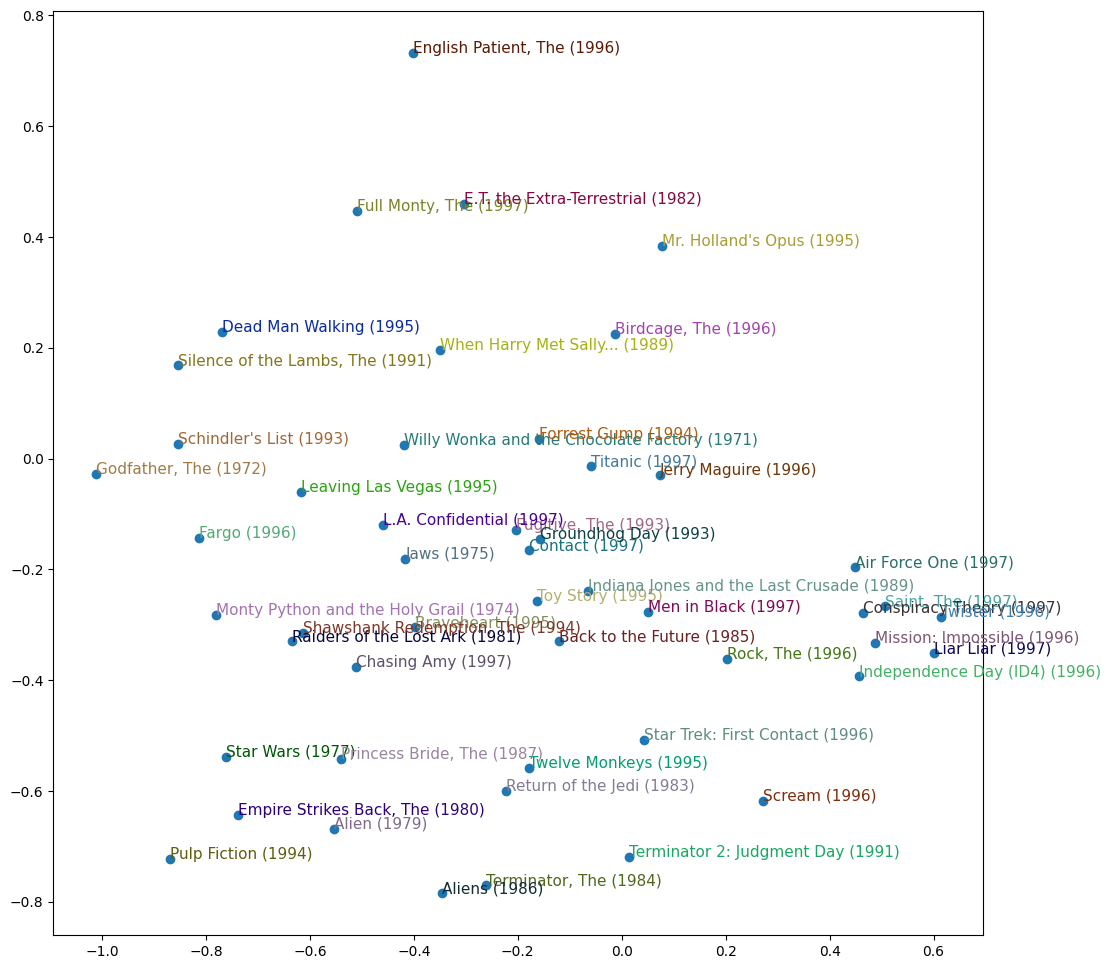

In [24]:
g = df.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Using Framework

Now that we've built a collaborative filtering model from scratch, it's time to make use of FastAI's framework, which is similar to what we ordinarily use as a machine learning practitioner.

In [25]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.865259,0.933339,00:10
1,0.666812,0.886678,00:10
2,0.500494,0.861727,00:11
3,0.455830,0.848820,00:11
4,0.434071,0.843161,00:11


We can easily look at the underlying structure of our model...

In [26]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

And we can access these layers using dot notation to generate the same information about the bias terms as before!

In [27]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 "Schindler's List (1993)",
 'Usual Suspects, The (1995)',
 'Star Wars (1977)']